In [2]:
!pip install -q catboost lightgbm xgboost imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


# Importing the Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# DATA LOADING AND INITIAL EXPLORATION

In [4]:
df = pd.read_csv('/content/train_dataset_final1.csv')

print("Dataset Shape:", df.shape)
df.columns.tolist()

Dataset Shape: (25247, 27)


['Customer_ID',
 'marriage',
 'sex',
 'education',
 'LIMIT_BAL',
 'age',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'Bill_amt1',
 'Bill_amt2',
 'Bill_amt3',
 'Bill_amt4',
 'Bill_amt5',
 'Bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'AVG_Bill_amt',
 'PAY_TO_BILL_ratio',
 'next_month_default']

In [5]:
df.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float64
 16  Bill

In [7]:
df.describe()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
count,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25121.000000,25247.000000,25247.000000,25247.000000,25247.000000,...,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000
mean,17640.000000,1.551907,0.604111,1.852101,168342.060443,35.438199,-0.042857,-0.159544,-0.190359,-0.241415,...,38806.221029,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44859.647485,0.362962,0.190399
std,7288.325459,0.522629,0.489050,0.797379,129892.784807,9.174998,1.099315,1.173990,1.172636,1.146753,...,59182.792531,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62819.226119,5.047206,0.392624
min,5017.000000,0.000000,0.000000,0.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-56043.170000,-546.930000,0.000000
25%,11328.500000,1.000000,0.000000,1.000000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1241.710000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4858.670000,0.040000,0.000000
50%,17640.000000,2.000000,1.000000,2.000000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,17102.580000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21102.830000,0.090000,0.000000
75%,23951.500000,2.000000,1.000000,2.000000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,49245.195000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57136.580000,0.590000,0.000000
max,30263.000000,3.000000,1.000000,6.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,7.000000,...,961663.620000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877313.830000,205.380000,1.000000


In [8]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

age    126
dtype: int64


In [9]:
target_counts = df['next_month_default'].value_counts()
print(target_counts)
print(f"\nDefault Rate: {target_counts[1] / len(df) * 100:.2f}%")

next_month_default
0    20440
1     4807
Name: count, dtype: int64

Default Rate: 19.04%


# DATA PREPROCESSING AND CLEANING

In [10]:
# Handle missing values in age column (if any)
if df['age'].isnull().sum() > 0:
    df['age'].fillna(df['age'].median(), inplace=True)

In [11]:
# Check for any other missing values and fill them
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

In [12]:
# Check for outliers in key numerical columns
numerical_cols = ['LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    print(f"{col}: {outliers} outliers detected")

LIMIT_BAL: 148 outliers detected
age: 217 outliers detected
AVG_Bill_amt: 2158 outliers detected
PAY_TO_BILL_ratio: 829 outliers detected


# EXPLORATORY DATA ANALYSIS (EDA)

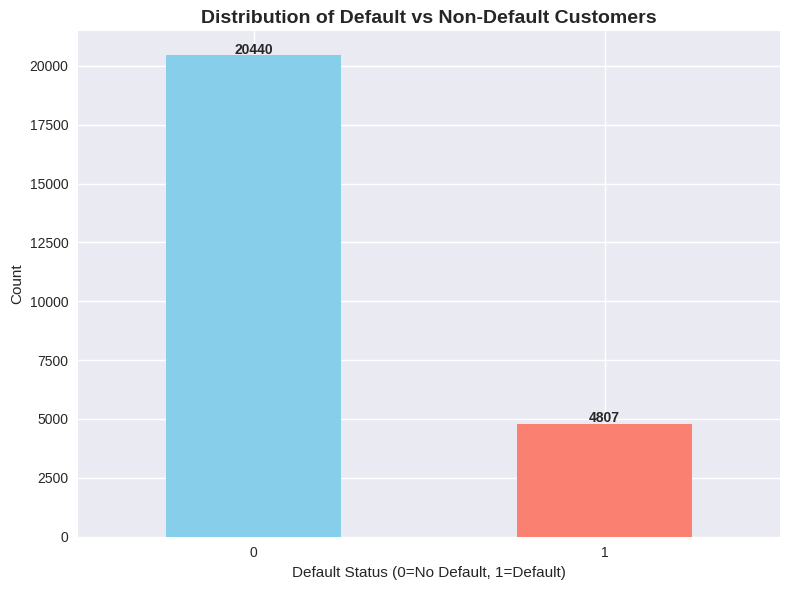

In [13]:
# Set up the plotting parameters
plt.rcParams['figure.figsize'] = (15, 10)

plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Default vs Non-Default Customers', fontsize=14, fontweight='bold')
plt.xlabel('Default Status (0=No Default, 1=Default)')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

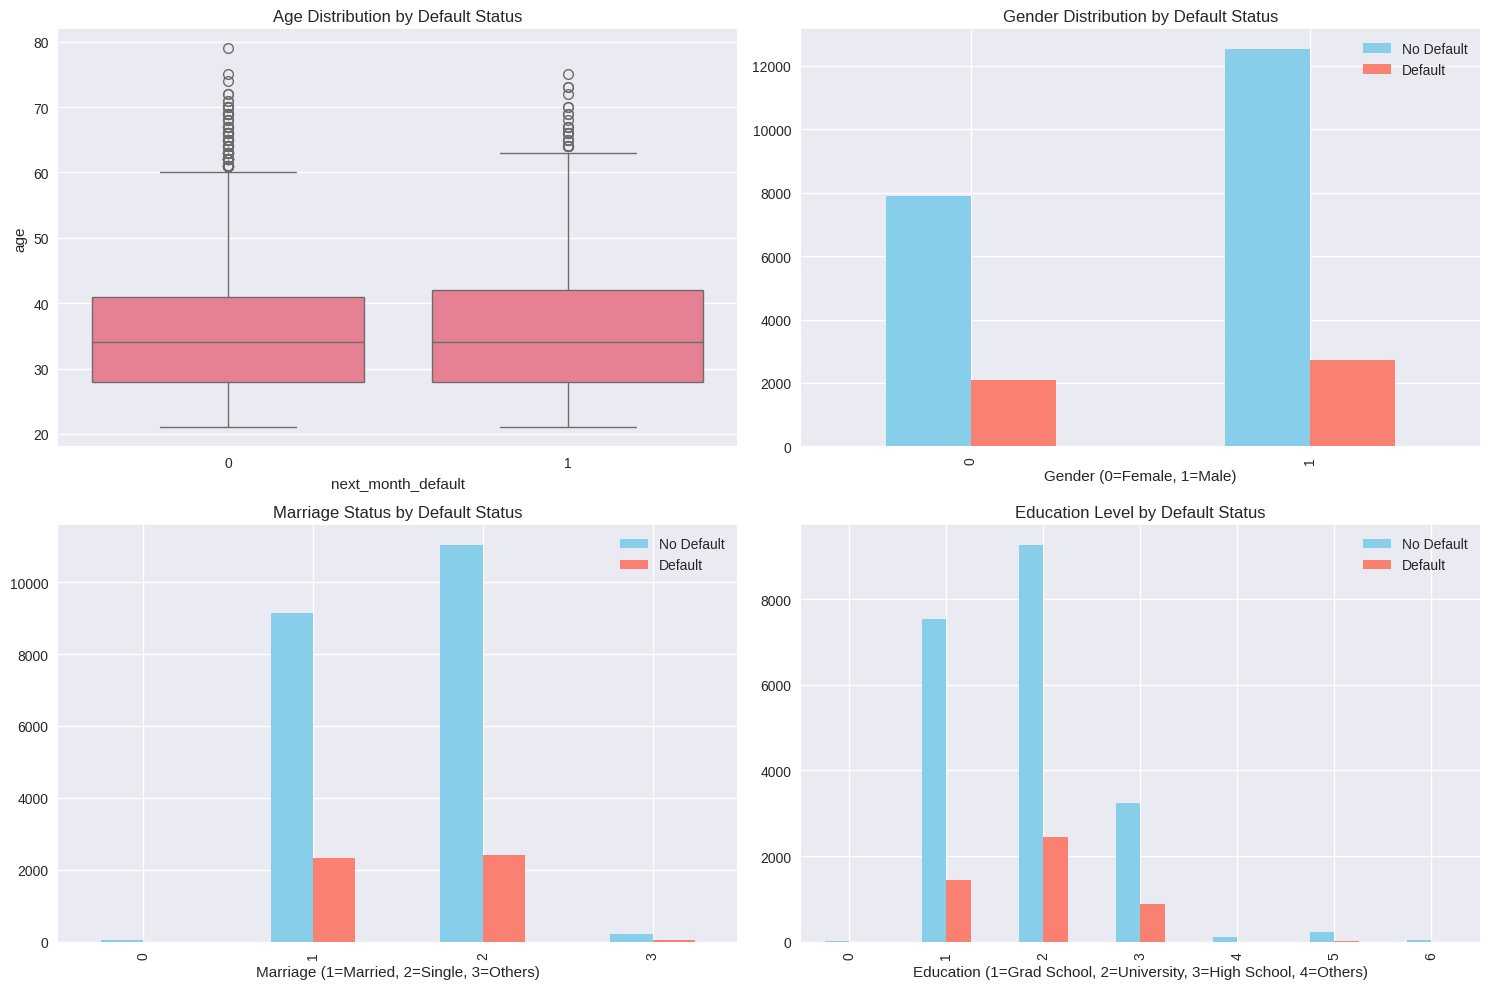

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution by default
sns.boxplot(data=df, x='next_month_default', y='age', ax=axes[0,0])
axes[0,0].set_title('Age Distribution by Default Status')

# Gender distribution by default
gender_default = df.groupby(['sex', 'next_month_default']).size().unstack()
gender_default.plot(kind='bar', ax=axes[0,1], color=['skyblue', 'salmon'])
axes[0,1].set_title('Gender Distribution by Default Status')
axes[0,1].set_xlabel('Gender (0=Female, 1=Male)')
axes[0,1].legend(['No Default', 'Default'])

# Marriage status by default
marriage_default = df.groupby(['marriage', 'next_month_default']).size().unstack()
marriage_default.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'salmon'])
axes[1,0].set_title('Marriage Status by Default Status')
axes[1,0].set_xlabel('Marriage (1=Married, 2=Single, 3=Others)')
axes[1,0].legend(['No Default', 'Default'])

# Education by default
education_default = df.groupby(['education', 'next_month_default']).size().unstack()
education_default.plot(kind='bar', ax=axes[1,1], color=['skyblue', 'salmon'])
axes[1,1].set_title('Education Level by Default Status')
axes[1,1].set_xlabel('Education (1=Grad School, 2=University, 3=High School, 4=Others)')
axes[1,1].legend(['No Default', 'Default'])

plt.tight_layout()
plt.show()

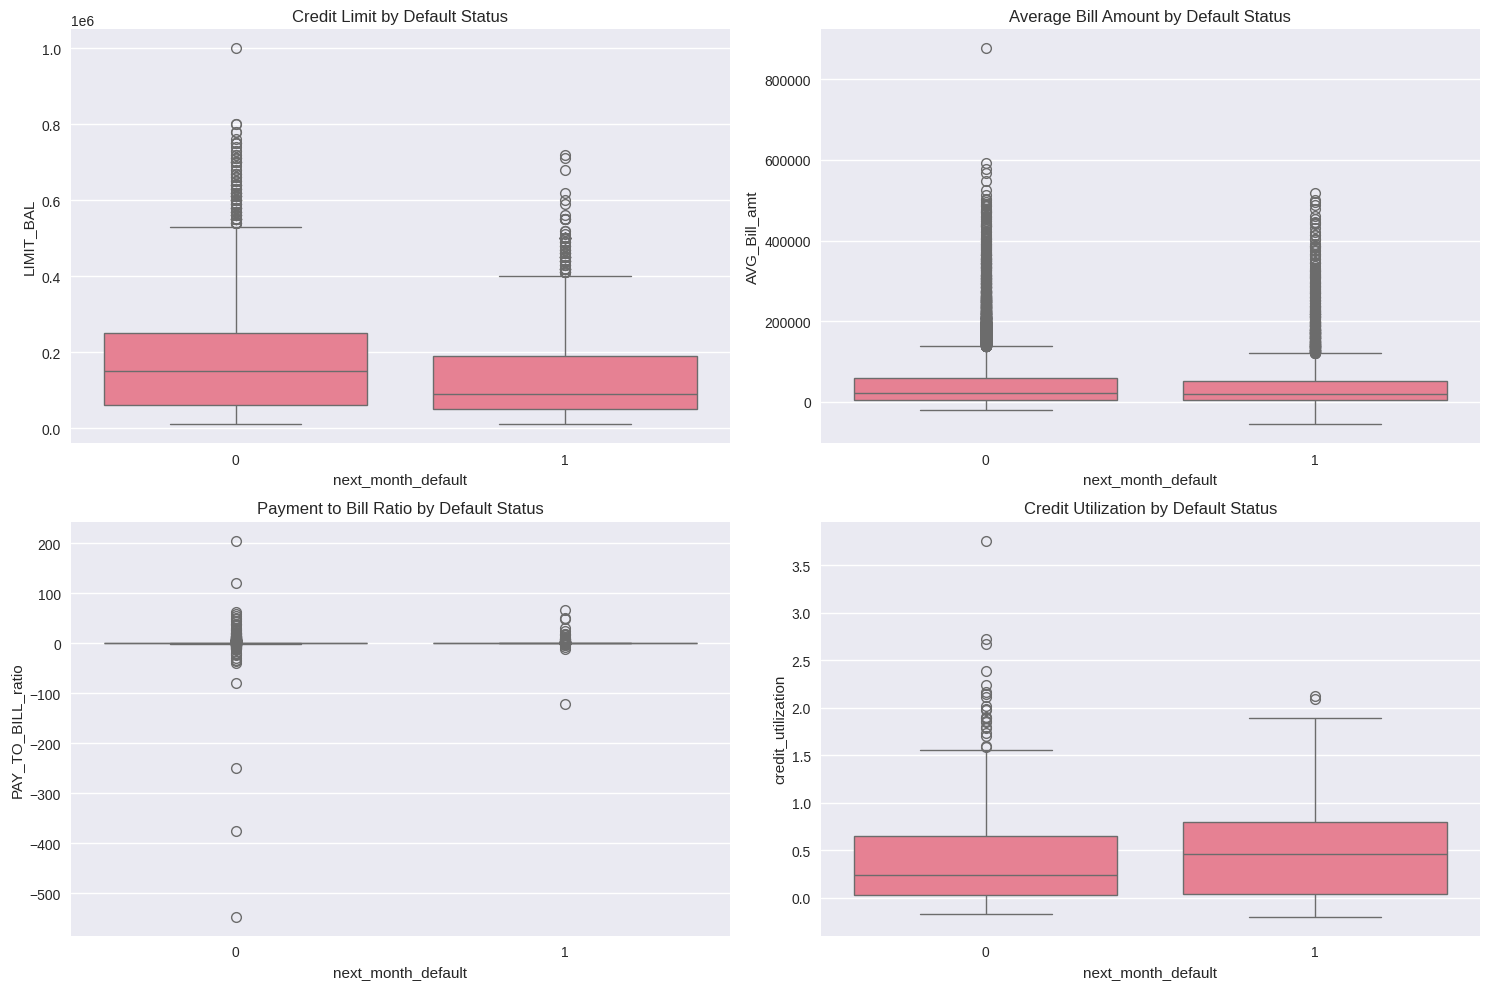

In [15]:
# Financial behavior analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Credit limit distribution
sns.boxplot(data=df, x='next_month_default', y='LIMIT_BAL', ax=axes[0,0])
axes[0,0].set_title('Credit Limit by Default Status')

# Average bill amount distribution
sns.boxplot(data=df, x='next_month_default', y='AVG_Bill_amt', ax=axes[0,1])
axes[0,1].set_title('Average Bill Amount by Default Status')

# Payment to bill ratio distribution
sns.boxplot(data=df, x='next_month_default', y='PAY_TO_BILL_ratio', ax=axes[1,0])
axes[1,0].set_title('Payment to Bill Ratio by Default Status')

# Credit utilization (AVG_Bill_amt / LIMIT_BAL)
df['credit_utilization'] = df['AVG_Bill_amt'] / df['LIMIT_BAL']
sns.boxplot(data=df, x='next_month_default', y='credit_utilization', ax=axes[1,1])
axes[1,1].set_title('Credit Utilization by Default Status')

plt.tight_layout()
plt.show()

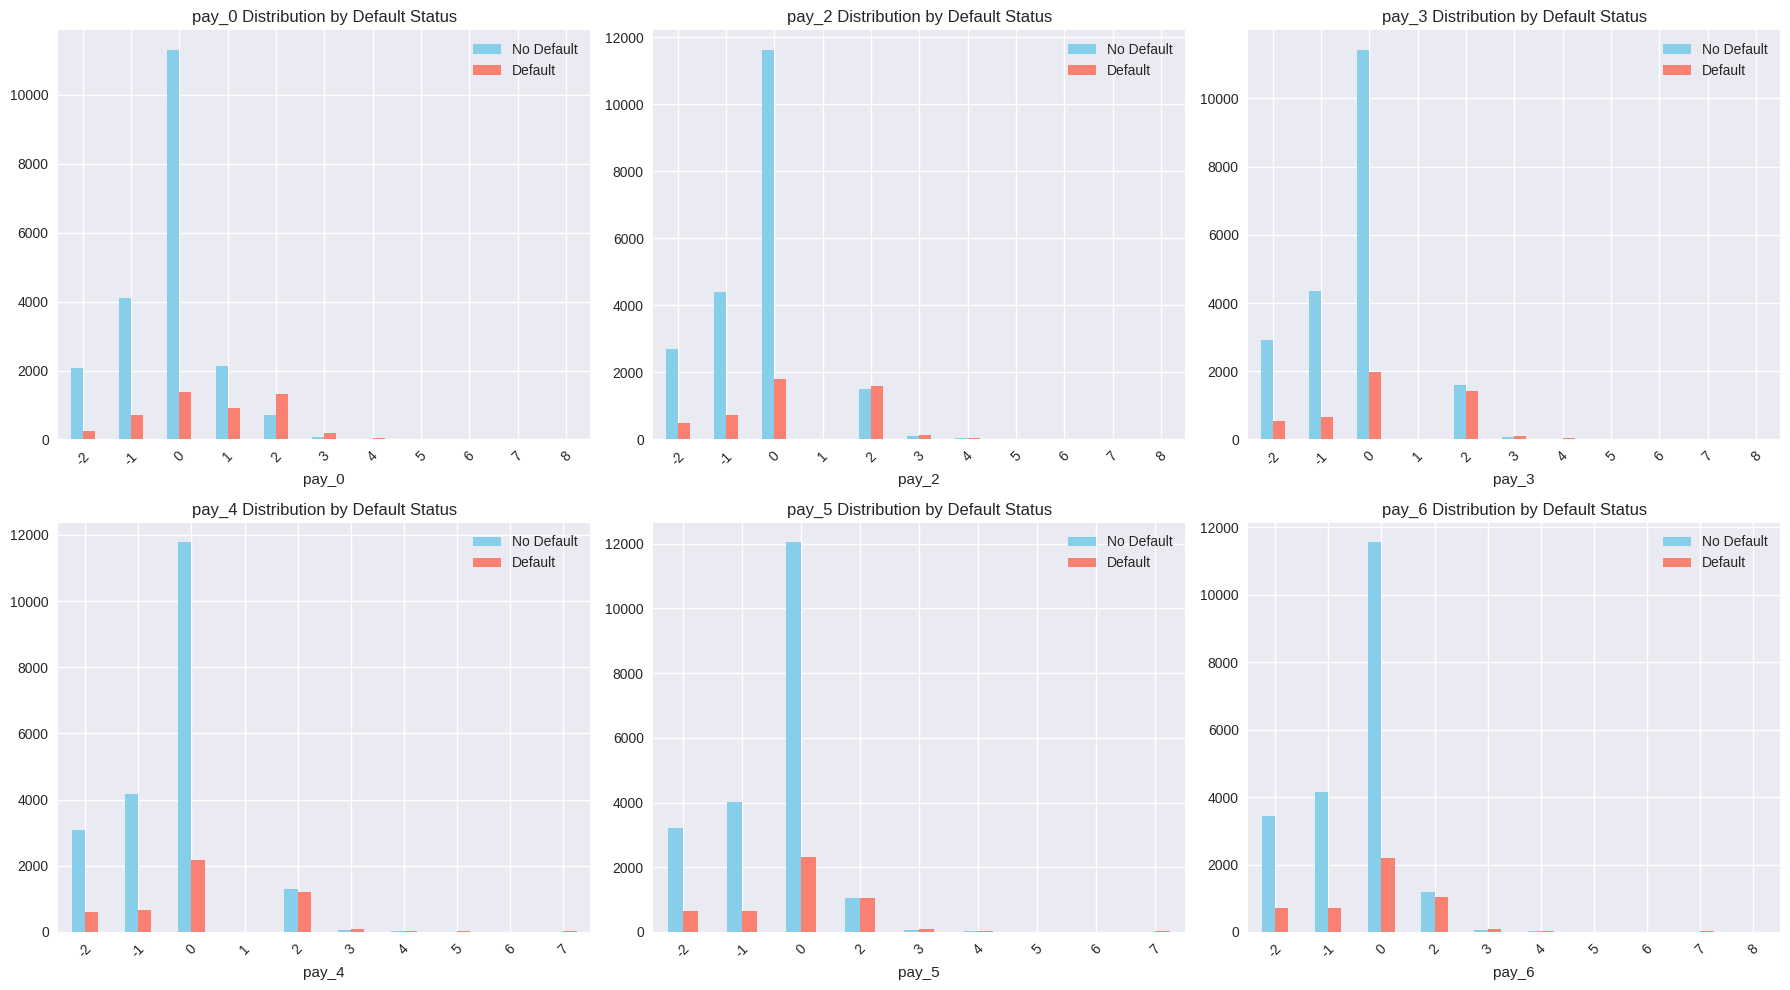

In [16]:
payment_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(payment_cols):
    payment_default = df.groupby([col, 'next_month_default']).size().unstack(fill_value=0)
    payment_default.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    axes[i].set_title(f'{col} Distribution by Default Status')
    axes[i].legend(['No Default', 'Default'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

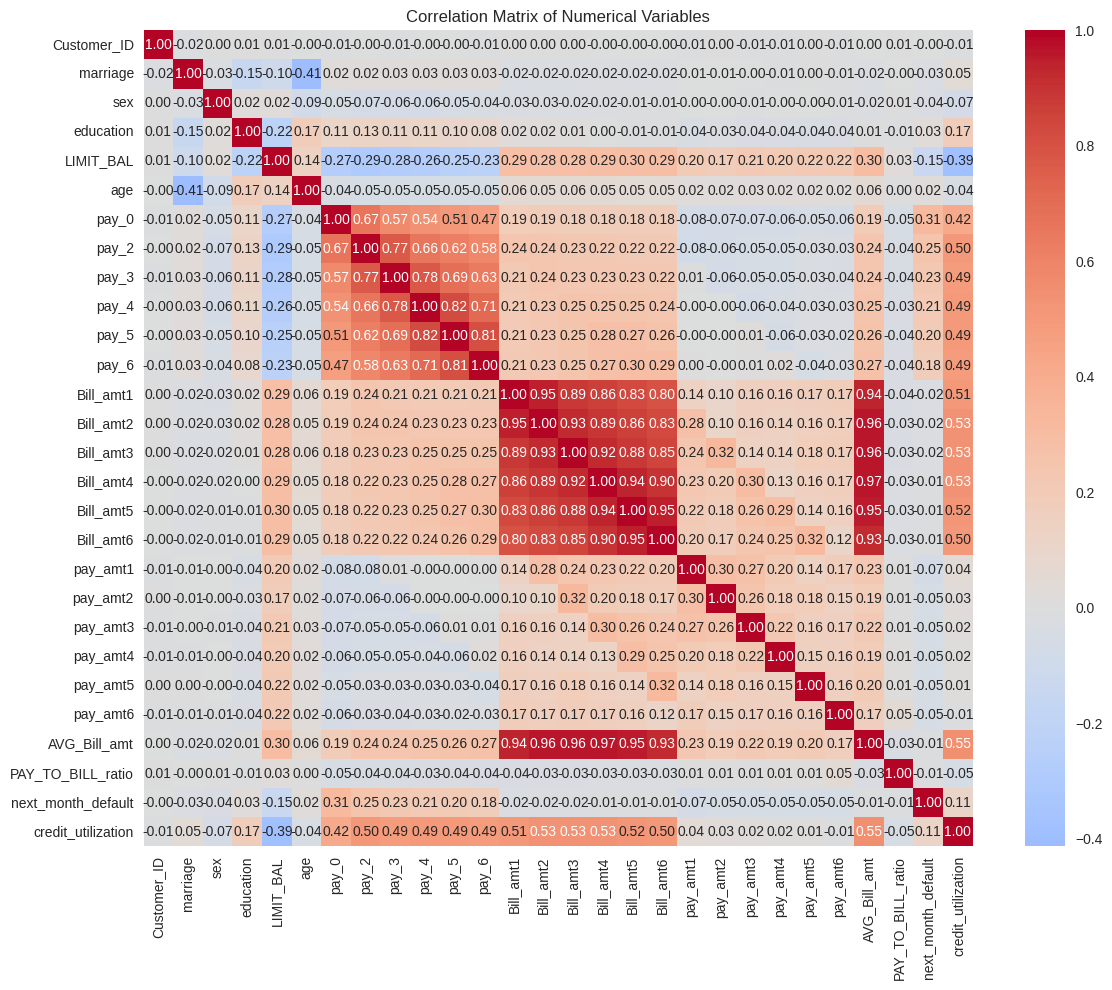

In [17]:
# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

# FEATURE ENGINEERING

In [18]:
df_features = df.copy()

df_features['credit_utilization'] = df_features['AVG_Bill_amt'] / df_features['LIMIT_BAL']

payment_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df_features['on_time_payments'] = (df_features[payment_cols] == -1).sum(axis=1)
df_features['payment_consistency'] = df_features['on_time_payments'] / 6

df_features['late_payments'] = (df_features[payment_cols] > 0).sum(axis=1)
df_features['delinquency_score'] = df_features['late_payments'] / 6

df_features['max_delinquency'] = df_features[payment_cols].max(axis=1)

In [19]:
recent_payment_cols = ['pay_0', 'pay_2', 'pay_3']
df_features['recent_late_payments'] = (df_features[recent_payment_cols] > 0).sum(axis=1)

bill_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
df_features['bill_trend'] = df_features['Bill_amt1'] - df_features['Bill_amt6']

pay_amount_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
df_features['payment_trend'] = df_features['pay_amt1'] - df_features['pay_amt6']


df_features['age_group'] = pd.cut(df_features['age'], bins=[0, 30, 40, 50, 100], labels=['Young', 'Adult', 'Middle', 'Senior'])

df_features['credit_limit_category'] = pd.cut(df_features['LIMIT_BAL'],
                                            bins=[0, 50000, 150000, 300000, float('inf')],
                                            labels=['Low', 'Medium', 'High', 'Very_High'])

df_features['payment_behavior'] = 'Good'
df_features.loc[df_features['delinquency_score'] > 0.3, 'payment_behavior'] = 'Poor'
df_features.loc[(df_features['delinquency_score'] > 0.1) & (df_features['delinquency_score'] <= 0.3), 'payment_behavior'] = 'Average'

In [20]:
print(f"Original features: {df.shape[1]}")
print(f"Total features after engineering: {df_features.shape[1]}")

Original features: 28
Total features after engineering: 39


In [21]:
# Display new features
new_features = ['credit_utilization', 'payment_consistency', 'delinquency_score',
                'max_delinquency', 'recent_late_payments', 'bill_trend', 'payment_trend']
print(df_features[new_features].describe())

       credit_utilization  payment_consistency  delinquency_score  \
count        25247.000000         25247.000000       25247.000000   
mean             0.370435             0.193726           0.130986   
std              0.349451             0.321849           0.251217   
min             -0.200154             0.000000           0.000000   
25%              0.029802             0.000000           0.000000   
50%              0.280751             0.000000           0.000000   
75%              0.682001             0.333333           0.166667   
max              3.759125             1.000000           1.000000   

       max_delinquency  recent_late_payments     bill_trend  payment_trend  
count     25247.000000          25247.000000   25247.000000   25247.000000  
mean          0.401671              0.485048   12364.666910     448.125679  
std           1.321125              0.922792   43957.629671   22375.536200  
min          -2.000000              0.000000 -428790.220000 -528666.07

#  FEATURE SELECTION AND PREPARATION

In [22]:
le_age_group = LabelEncoder()
le_credit_limit = LabelEncoder()
le_payment_behavior = LabelEncoder()

df_features['age_group_encoded'] = le_age_group.fit_transform(df_features['age_group'])
df_features['credit_limit_category_encoded'] = le_credit_limit.fit_transform(df_features['credit_limit_category'])
df_features['payment_behavior_encoded'] = le_payment_behavior.fit_transform(df_features['payment_behavior'])

In [23]:
feature_columns = [
    # Original features
    'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
    'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
    'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
    'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
    'AVG_Bill_amt', 'PAY_TO_BILL_ratio',

    # Engineered features
    'credit_utilization', 'payment_consistency', 'delinquency_score',
    'max_delinquency', 'recent_late_payments', 'bill_trend', 'payment_trend',
    'age_group_encoded', 'credit_limit_category_encoded', 'payment_behavior_encoded'
]

X = df_features[feature_columns]
y = df_features['next_month_default']

In [24]:
print(X.shape)
print(y.shape)

(25247, 35)
(25247,)


# TRAIN-TEST SPLIT

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)

(20197, 35)
(5050, 35)


# HANDLING CLASS IMBALANCE

In [26]:
print(y_train.value_counts())


smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE balancing:")
print(pd.Series(y_train_balanced).value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

next_month_default
0    16352
1     3845
Name: count, dtype: int64

After SMOTE balancing:
next_month_default
0    16352
1    16352
Name: count, dtype: int64


#  MODEL TRAINING AND EVALUATION

In [27]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
}


results = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating models...")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for logistic regression, original for tree-based models
    if name == 'Logistic Regression':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train_balanced
        X_test_model = X_test

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_model, y_train_balanced, cv=cv, scoring='roc_auc')


    model.fit(X_train_model, y_train_balanced)

    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Test AUC: {auc_roc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

Training and evaluating models...

Training Logistic Regression...
CV AUC: 0.8478 (+/- 0.0018)
Test AUC: 0.7167
Accuracy: 0.7552
Precision: 0.3892
Recall: 0.5000
F1-Score: 0.4377

Training Decision Tree...
CV AUC: 0.8916 (+/- 0.0069)
Test AUC: 0.7254
Accuracy: 0.7913
Precision: 0.4536
Recall: 0.4678
F1-Score: 0.4606

Training Random Forest...
CV AUC: 0.9517 (+/- 0.0028)
Test AUC: 0.7755
Accuracy: 0.8275
Precision: 0.5674
Recall: 0.3981
F1-Score: 0.4679

Training XGBoost...
CV AUC: 0.9439 (+/- 0.0060)
Test AUC: 0.7582
Accuracy: 0.8236
Precision: 0.5559
Recall: 0.3669
F1-Score: 0.4421

Training LightGBM...
CV AUC: 0.9441 (+/- 0.0065)
Test AUC: 0.7743
Accuracy: 0.8317
Precision: 0.5909
Recall: 0.3784
F1-Score: 0.4613

Training CatBoost...
CV AUC: 0.9462 (+/- 0.0070)
Test AUC: 0.7672
Accuracy: 0.8345
Precision: 0.6050
Recall: 0.3773
F1-Score: 0.4648


# MODEL COMPARISON AND VISUALIZATION


Model Comparison Results:
                 Model  CV_AUC_Mean  CV_AUC_Std  Test_AUC  Accuracy  \
0  Logistic Regression       0.8478      0.0009    0.7167    0.7552   
1        Decision Tree       0.8916      0.0035    0.7254    0.7913   
2        Random Forest       0.9517      0.0014    0.7755    0.8275   
3              XGBoost       0.9439      0.0030    0.7582    0.8236   
4             LightGBM       0.9441      0.0032    0.7743    0.8317   
5             CatBoost       0.9462      0.0035    0.7672    0.8345   

   Precision  Recall  F1_Score  
0     0.3892  0.5000    0.4377  
1     0.4536  0.4678    0.4606  
2     0.5674  0.3981    0.4679  
3     0.5559  0.3669    0.4421  
4     0.5909  0.3784    0.4613  
5     0.6050  0.3773    0.4648  


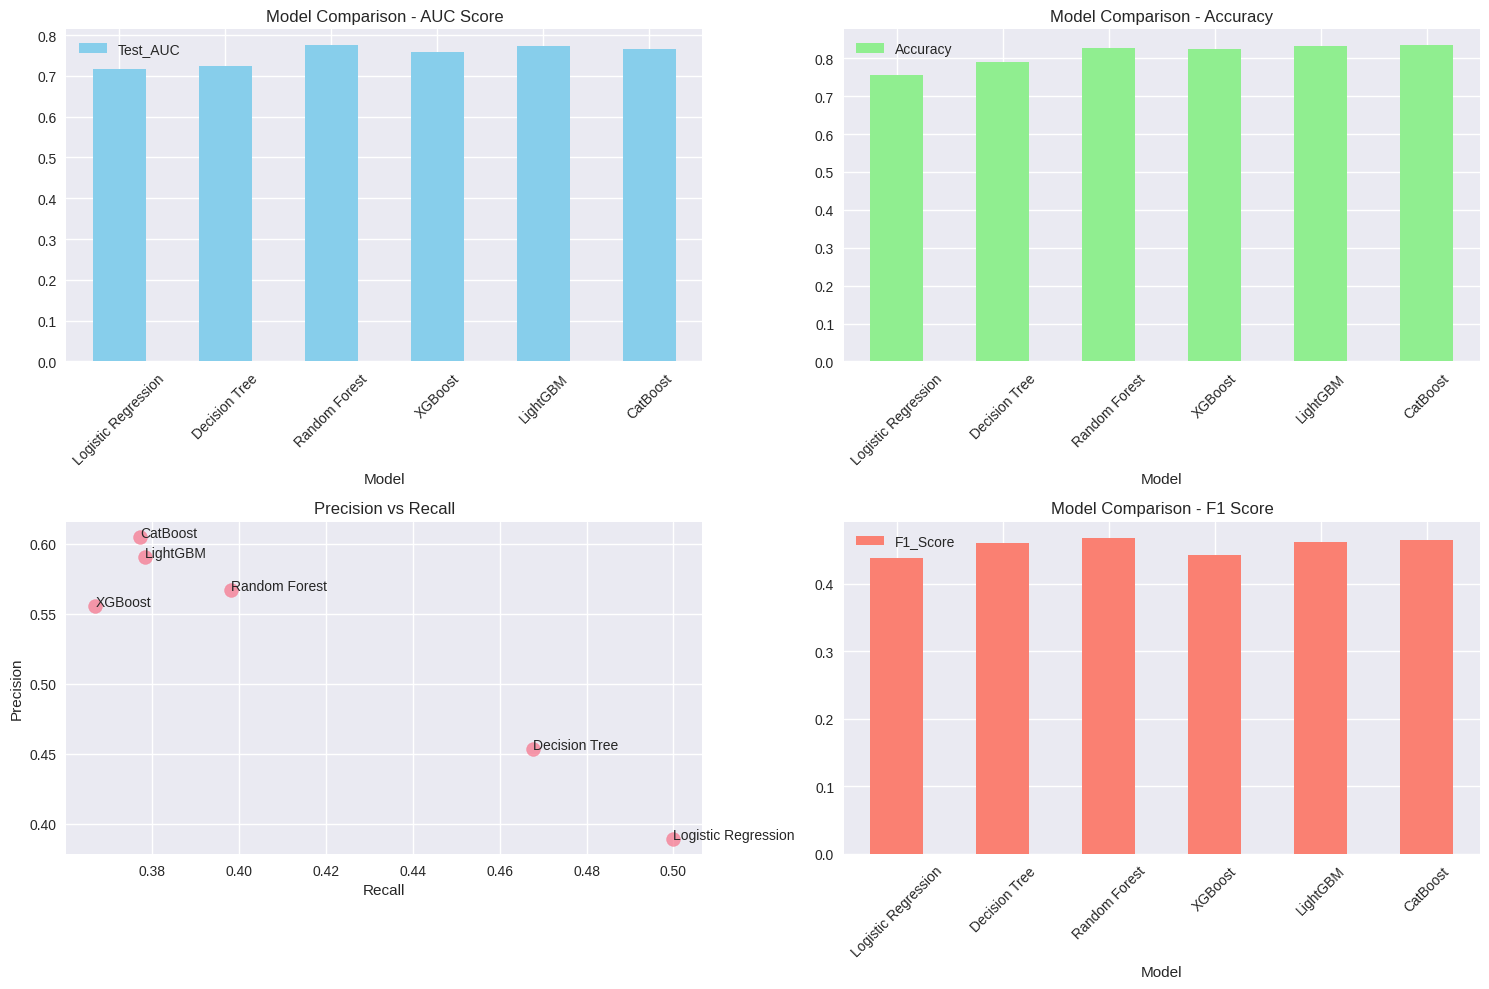

In [28]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_AUC_Mean': [results[model]['cv_auc_mean'] for model in results.keys()],
    'CV_AUC_Std': [results[model]['cv_auc_std'] for model in results.keys()],
    'Test_AUC': [results[model]['auc_roc'] for model in results.keys()],
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1_Score': [results[model]['f1_score'] for model in results.keys()]
})

print("\nModel Comparison Results:")
print("="*50)
print(results_df.round(4))

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))


results_df.plot(x='Model', y='Test_AUC', kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Model Comparison - AUC Score')
axes[0,0].tick_params(axis='x', rotation=45)


results_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Model Comparison - Accuracy')
axes[0,1].tick_params(axis='x', rotation=45)


axes[1,0].scatter(results_df['Recall'], results_df['Precision'], s=100, alpha=0.7)
for i, model in enumerate(results_df['Model']):
    axes[1,0].annotate(model, (results_df['Recall'].iloc[i], results_df['Precision'].iloc[i]))
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision vs Recall')


results_df.plot(x='Model', y='F1_Score', kind='bar', ax=axes[1,1], color='salmon')
axes[1,1].set_title('Model Comparison - F1 Score')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# BEST MODEL SELECTION AND ROC CURVES


Best Model: CatBoost
Best AUC Score: 0.7672


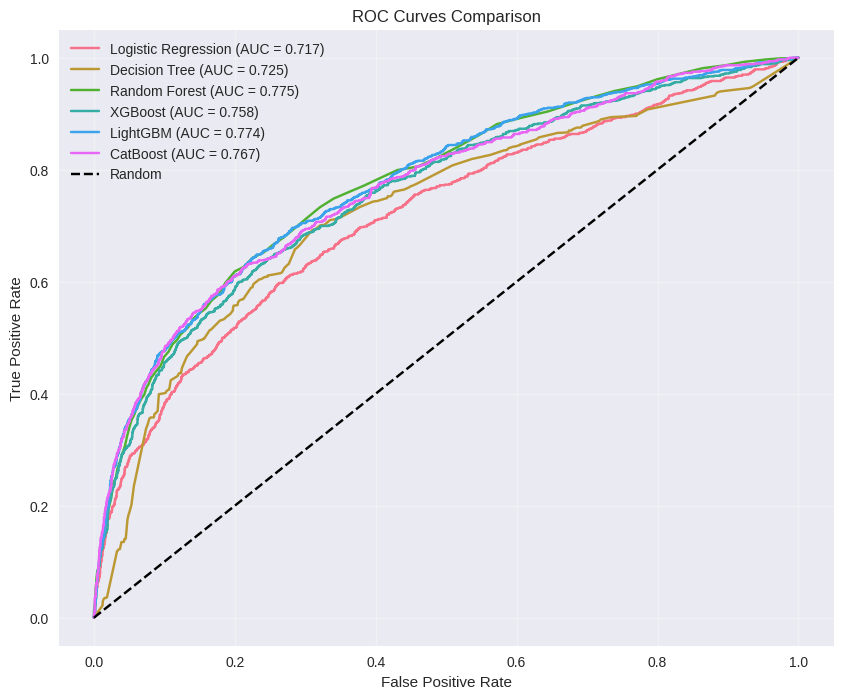

In [29]:
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Best AUC Score: {results[best_model_name]['auc_roc']:.4f}")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    auc_score = results[name]['auc_roc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

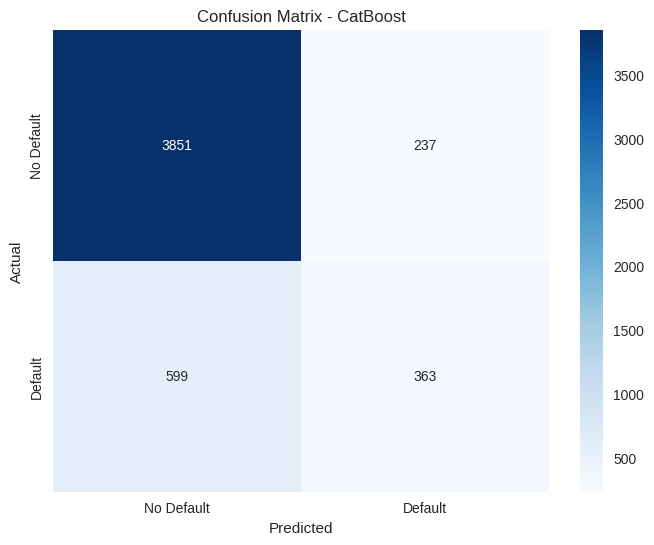

In [30]:
# Confusion matrix for best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# FEATURE IMPORTANCE

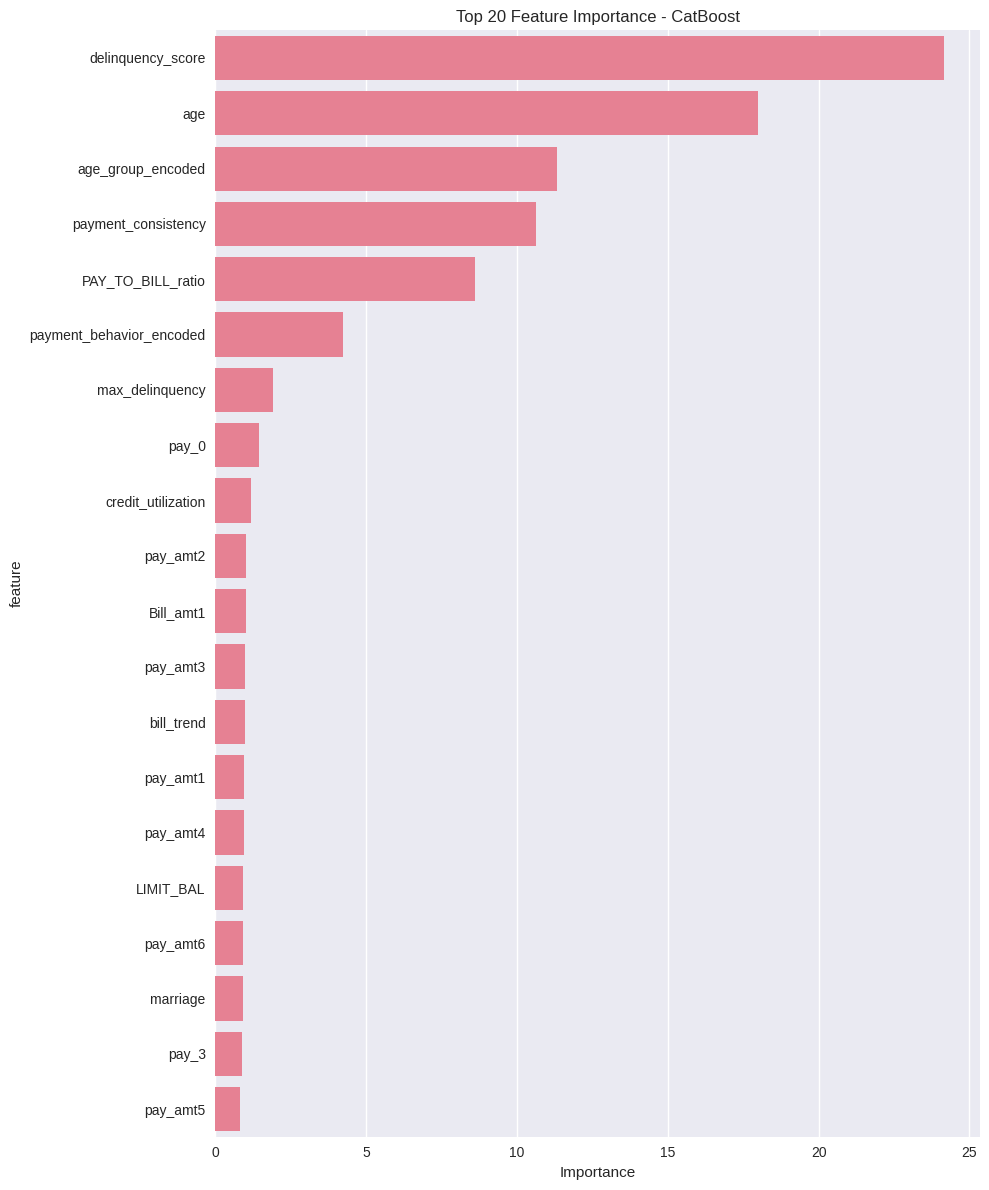

Top 10 Most Important Features:
                     feature  importance
27         delinquency_score   24.142571
4                        age   17.998617
32         age_group_encoded   11.333110
26       payment_consistency   10.631745
24         PAY_TO_BILL_ratio    8.613063
34  payment_behavior_encoded    4.216499
28           max_delinquency    1.902527
5                      pay_0    1.429901
25        credit_utilization    1.178909
18                  pay_amt2    1.008868


In [31]:
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']:

    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
    elif hasattr(best_model, 'get_feature_importance'):
        importance = best_model.get_feature_importance()


    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importance
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(10, 12))
    top_features = feature_importance_df.head(20)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10))

# THRESHOLD OPTIMIZATION

In [36]:
# Find optimal threshold for best model
best_y_pred_proba = results[best_model_name]['y_pred_proba']

# Calculate precision-recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, best_y_pred_proba)

# Calculate F1 scores for different thresholds
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals)
f1_scores = f1_scores[:-1]  # Remove last element to match thresholds length

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\nThreshold Optimization Results:")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Optimal F1 Score: {optimal_f1:.4f}")


Threshold Optimization Results:
Optimal Threshold: 0.3389
Optimal F1 Score: 0.5089


In [37]:
# Apply optimal threshold
y_pred_optimal = (best_y_pred_proba >= optimal_threshold).astype(int)

# Calculate metrics with optimal threshold
optimal_accuracy = accuracy_score(y_test, y_pred_optimal)
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1_actual = f1_score(y_test, y_pred_optimal)

print(f"\nMetrics with Optimal Threshold:")
print(f"Accuracy: {optimal_accuracy:.4f}")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall: {optimal_recall:.4f}")
print(f"F1 Score: {optimal_f1_actual:.4f}")


Metrics with Optimal Threshold:
Accuracy: 0.8097
Precision: 0.5005
Recall: 0.5177
F1 Score: 0.5089


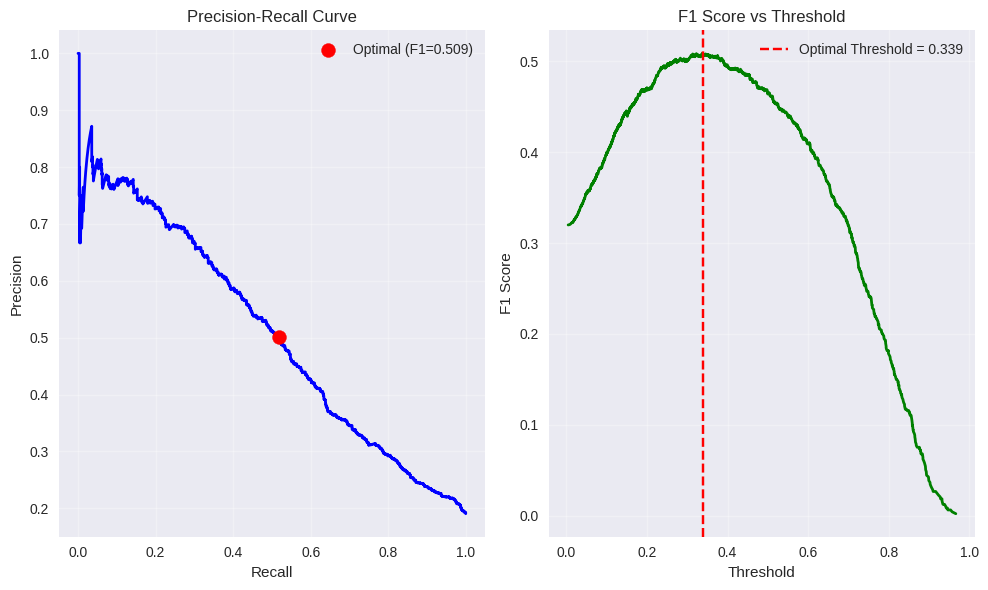

In [38]:
# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(recall_vals, precision_vals, 'b-', linewidth=2)
plt.scatter(recall_vals[optimal_idx], precision_vals[optimal_idx],
           color='red', s=100, zorder=5, label=f'Optimal (F1={optimal_f1:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot F1 scores vs thresholds
plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores, 'g-', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--',
           label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# BUSINESS INSIGHTS AND RECOMMENDATIONS

In [39]:
# Default rate by different segments
print("\n1. DEFAULT RATES BY CUSTOMER SEGMENTS:")
print("-" * 40)

# By payment behavior
payment_behavior_default = df_features.groupby(['payment_behavior', 'next_month_default']).size().unstack(fill_value=0)
payment_behavior_rates = payment_behavior_default[1] / payment_behavior_default.sum(axis=1) * 100
print("Default Rate by Payment Behavior:")
for behavior, rate in payment_behavior_rates.items():
    print(f"  {behavior}: {rate:.2f}%")

# By credit limit category
credit_limit_default = df_features.groupby(['credit_limit_category', 'next_month_default']).size().unstack(fill_value=0)
credit_limit_rates = credit_limit_default[1] / credit_limit_default.sum(axis=1) * 100
print("\nDefault Rate by Credit Limit Category:")
for category, rate in credit_limit_rates.items():
    print(f"  {category}: {rate:.2f}%")

# By age group
age_group_default = df_features.groupby(['age_group', 'next_month_default']).size().unstack(fill_value=0)
age_group_rates = age_group_default[1] / age_group_default.sum(axis=1) * 100
print("\nDefault Rate by Age Group:")
for group, rate in age_group_rates.items():
    print(f"  {group}: {rate:.2f}%")


1. DEFAULT RATES BY CUSTOMER SEGMENTS:
----------------------------------------
Default Rate by Payment Behavior:
  Average: 25.95%
  Good: 9.92%
  Poor: 48.26%

Default Rate by Credit Limit Category:
  Low: 27.76%
  Medium: 20.49%
  High: 14.36%
  Very_High: 11.17%

Default Rate by Age Group:
  Young: 19.41%
  Adult: 17.29%
  Middle: 20.09%
  Senior: 22.99%


In [ ]:
print(f"Best Model: {best_model_name}")
print(f"AUC Score: {results[best_model_name]['auc_roc']:.4f}")
print(f"Accuracy: {optimal_accuracy:.4f}")
print(f"Precision: {optimal_precision:.4f} (of predicted defaults, {optimal_precision*100:.1f}% are actual defaults)")
print(f"Recall: {optimal_recall:.4f} (captures {optimal_recall*100:.1f}% of all actual defaults)")


3. MODEL PERFORMANCE SUMMARY:
----------------------------------------
Best Model: CatBoost
AUC Score: 0.7672
Accuracy: 0.8097
Precision: 0.5005 (of predicted defaults, 50.1% are actual defaults)
Recall: 0.5177 (captures 51.8% of all actual defaults)


# FINAL MODEL TRAINING ON FULL DATA

In [40]:
# Train the best model on full dataset for final predictions
print(f"\nTraining final {best_model_name} model on complete dataset...")

# Use the same preprocessing pipeline
X_full_balanced, y_full_balanced = smote.fit_resample(X, y)

final_model = CatBoostClassifier(random_state=42, verbose=False)

final_model.fit(X_full_balanced, y_full_balanced)

print("Final model training completed!")


Training final CatBoost model on complete dataset...
Final model training completed!


In [41]:
def predict_default_risk(customer_data):

    # Apply same feature engineering
    customer_features = customer_data.copy()

    # Credit utilization
    customer_features['credit_utilization'] = customer_features['AVG_Bill_amt'] / customer_features['LIMIT_BAL']

    # Payment consistency
    payment_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    customer_features['on_time_payments'] = (customer_features[payment_cols] == -1).sum(axis=1)
    customer_features['payment_consistency'] = customer_features['on_time_payments'] / 6

    # Delinquency score
    customer_features['late_payments'] = (customer_features[payment_cols] > 0).sum(axis=1)
    customer_features['delinquency_score'] = customer_features['late_payments'] / 6

    # Maximum delinquency
    customer_features['max_delinquency'] = customer_features[payment_cols].max(axis=1)

    # Recent payment behavior
    recent_payment_cols = ['pay_0', 'pay_2', 'pay_3']
    customer_features['recent_late_payments'] = (customer_features[recent_payment_cols] > 0).sum(axis=1)

    # Bill and payment trends
    bill_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
    customer_features['bill_trend'] = customer_features['Bill_amt1'] - customer_features['Bill_amt6']

    pay_amount_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
    customer_features['payment_trend'] = customer_features['pay_amt1'] - customer_features['pay_amt6']

    # Categorical encodings (simplified)
    customer_features['age_group_encoded'] = 1
    customer_features['credit_limit_category_encoded'] = 1
    customer_features['payment_behavior_encoded'] = 1

    # Select features
    X_customer = customer_features[feature_columns]

    # Scale if needed
    if best_model_name == 'Logistic Regression':
        X_customer_scaled = scaler_full.transform(X_customer)
        predictions_proba = final_model.predict_proba(X_customer_scaled)[:, 1]
    else:
        predictions_proba = final_model.predict_proba(X_customer)[:, 1]

    predictions = (predictions_proba >= optimal_threshold).astype(int)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Customer_ID': customer_data['Customer_ID'],
        'default_probability': predictions_proba,
        'next_month_default': predictions,
        'risk_level': ['High' if p >= 0.7 else 'Medium' if p >= 0.3 else 'Low' for p in predictions_proba]
    })

    return results_df

In [42]:
sample_indices = np.random.choice(X_test.index, 10, replace=False)
sample_data = df.loc[sample_indices]

print("Testing predict_default_risk function...")
sample_predictions = predict_default_risk(sample_data)

print("\nSample Predictions using predict_default_risk function:")
print(sample_predictions.round(4))

Testing predict_default_risk function...

Sample Predictions using predict_default_risk function:
       Customer_ID  default_probability  next_month_default risk_level
16229        21246               0.4719                   1     Medium
21040        26057               0.1826                   0        Low
23761        28778               0.9733                   1       High
1430          6447               0.9692                   1       High
5477         10494               0.9964                   1       High
11022        16039               0.8309                   1       High
20288        25305               0.0593                   0        Low
22082        27099               0.9958                   1       High
17197        22214               0.3473                   1     Medium
16446        21463               0.8799                   1       High


In [43]:
# Compare with actual values
actual_defaults = y_test.loc[sample_indices].values
comparison_df = sample_predictions.copy()
comparison_df['Actual_Default'] = actual_defaults
comparison_df['Correct_Prediction'] = (comparison_df['next_month_default'] == comparison_df['Actual_Default'])

print("\nPrediction Accuracy Check:")
print(comparison_df[['Customer_ID', 'Actual_Default', 'next_month_default', 'default_probability', 'Correct_Prediction']].round(4))

accuracy_rate = comparison_df['Correct_Prediction'].mean()
print(f"\nSample Accuracy: {accuracy_rate:.2%}")


Prediction Accuracy Check:
       Customer_ID  Actual_Default  next_month_default  default_probability  \
16229        21246               0                   1               0.4719   
21040        26057               1                   0               0.1826   
23761        28778               1                   1               0.9733   
1430          6447               0                   1               0.9692   
5477         10494               0                   1               0.9964   
11022        16039               0                   1               0.8309   
20288        25305               0                   0               0.0593   
22082        27099               1                   1               0.9958   
17197        22214               0                   1               0.3473   
16446        21463               0                   1               0.8799   

       Correct_Prediction  
16229               False  
21040               False  
23761             

#VALIDATION DATASET PREDICTION TEMPLATE

In [48]:
def make_validation_predictions(validation_file_path):
    """
    Make predictions on validation set with proper feature engineering
    matching the training set exactly
    """
    val_df = pd.read_csv(validation_file_path)
    val_features = val_df.copy()

    print(val_df.shape)
    # Handle missing values (same as training)
    for col in val_features.columns:
        if val_features[col].isnull().sum() > 0:
            if val_features[col].dtype in ['int64', 'float64']:
                val_features[col].fillna(val_features[col].median(), inplace=True)
            else:
                val_features[col].fillna(val_features[col].mode()[0], inplace=True)

    # FEATURE ENGINEERING - EXACT SAME AS TRAINING SET

    # 1. Credit Utilization Ratio
    val_features['credit_utilization'] = val_features['AVG_Bill_amt'] / val_features['LIMIT_BAL']

    # 2. Payment Consistency Score (count of on-time payments)
    payment_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    val_features['on_time_payments'] = (val_features[payment_cols] == -1).sum(axis=1)
    val_features['payment_consistency'] = val_features['on_time_payments'] / 6

    # 3. Delinquency Score (count of late payments)
    val_features['late_payments'] = (val_features[payment_cols] > 0).sum(axis=1)
    val_features['delinquency_score'] = val_features['late_payments'] / 6

    # 4. Maximum delinquency months
    val_features['max_delinquency'] = val_features[payment_cols].max(axis=1)

    # 5. Recent payment behavior (last 3 months)
    recent_payment_cols = ['pay_0', 'pay_2', 'pay_3']
    val_features['recent_late_payments'] = (val_features[recent_payment_cols] > 0).sum(axis=1)

    # 6. Bill amount trend (using bill amounts)
    bill_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
    val_features['bill_trend'] = val_features['Bill_amt1'] - val_features['Bill_amt6']

    # 7. Payment amount trend
    pay_amount_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
    val_features['payment_trend'] = val_features['pay_amt1'] - val_features['pay_amt6']

    # 8. Age groups (same bins as training)
    val_features['age_group'] = pd.cut(val_features['age'],
                                      bins=[0, 30, 40, 50, 100],
                                      labels=['Young', 'Adult', 'Middle', 'Senior'])

    # 9. Credit limit categories (same bins as training)
    val_features['credit_limit_category'] = pd.cut(val_features['LIMIT_BAL'],
                                                  bins=[0, 50000, 150000, 300000, float('inf')],
                                                  labels=['Low', 'Medium', 'High', 'Very_High'])

    # 10. Payment behavior categories (same logic as training)
    val_features['payment_behavior'] = 'Good'
    val_features.loc[val_features['delinquency_score'] > 0.3, 'payment_behavior'] = 'Poor'
    val_features.loc[(val_features['delinquency_score'] > 0.1) &
                     (val_features['delinquency_score'] <= 0.3), 'payment_behavior'] = 'Average'



    # Option 1: If you have saved encoders from training (RECOMMENDED)
    val_features['age_group_encoded'] = le_age_group.transform(val_features['age_group'])
    val_features['credit_limit_category_encoded'] = le_credit_limit.transform(val_features['credit_limit_category'])
    val_features['payment_behavior_encoded'] = le_payment_behavior.transform(val_features['payment_behavior'])

    # Handle any missing values in encoded columns (fill with most common value)
    val_features['age_group_encoded'].fillna(val_features['age_group_encoded'].mode()[0], inplace=True)
    val_features['credit_limit_category_encoded'].fillna(val_features['credit_limit_category_encoded'].mode()[0], inplace=True)
    val_features['payment_behavior_encoded'].fillna(val_features['payment_behavior_encoded'].mode()[0], inplace=True)

    X_val = val_features[feature_columns]

    # Make predictions
    val_proba = final_model.predict_proba(X_val)[:, 1]

    # Apply optimal threshold
    val_predictions = (val_proba >= optimal_threshold).astype(int)

    # Create final predictions DataFrame
    final_predictions = pd.DataFrame({
        'Customer_ID': val_df['Customer_ID'],
        'next_month_default': val_predictions,
        'default_probability': val_proba  # Include probability for business use
    })

    return final_predictions, val_features


# Usage:
predictions, validation_features = make_validation_predictions('/content/validate_dataset_final.csv')
predictions.to_csv('final_predictions.csv', index=False)

print("\nPrediction Summary:")
print(f"Total customers: {len(predictions)}")
print(f"Predicted defaults: {predictions['next_month_default'].sum()}")
print(f"Default rate: {predictions['next_month_default'].mean():.2%}")
print(f"Average probability: {predictions['default_probability'].mean():.4f}")

(5016, 26)

Prediction Summary:
Total customers: 5016
Predicted defaults: 1018
Default rate: 20.30%
Average probability: 0.2218
